In [ ]:
!pip install kloppy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


In [ ]:
!pip install mplsoccer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
from kloppy import statsbomb
match_id = 15946
base_url = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data'
event_data_url = f"{base_url}/events/{match_id}.json"
lineup_data_url = f"{base_url}/lineups/{match_id}.json"
dataset = statsbomb.load(
    event_data=event_data_url,
    lineup_data=lineup_data_url,
    coordinates='statsbomb'
)
pass_data = dataset.filter('pass')
print("Pitch Dimensions:", dataset.metadata.pitch_dimensions)
print("Orientation:", dataset.metadata.orientation)
print("Coordinate System:", dataset.metadata.coordinate_system)
team1, team2 = dataset.metadata.teams
print("Teams:", team1.name, "vs", team2.name)

Pitch Dimensions: ImperialPitchDimensions(x_dim=Dimension(min=0, max=120), y_dim=Dimension(min=0, max=80), standardized=True, unit=<Unit.YARDS: 'y'>, goal_width=8, goal_height=2.66, six_yard_width=20, six_yard_length=6, penalty_area_width=44, penalty_area_length=18, circle_radius=10, corner_radius=1, penalty_spot_distance=12, penalty_arc_radius=10, pitch_length=None, pitch_width=None)
Orientation: Orientation.ACTION_EXECUTING_TEAM
Coordinate System: StatsBombCoordinateSystem(pitch_length=None, pitch_width=None)
Teams: Barcelona vs Deportivo Alavés


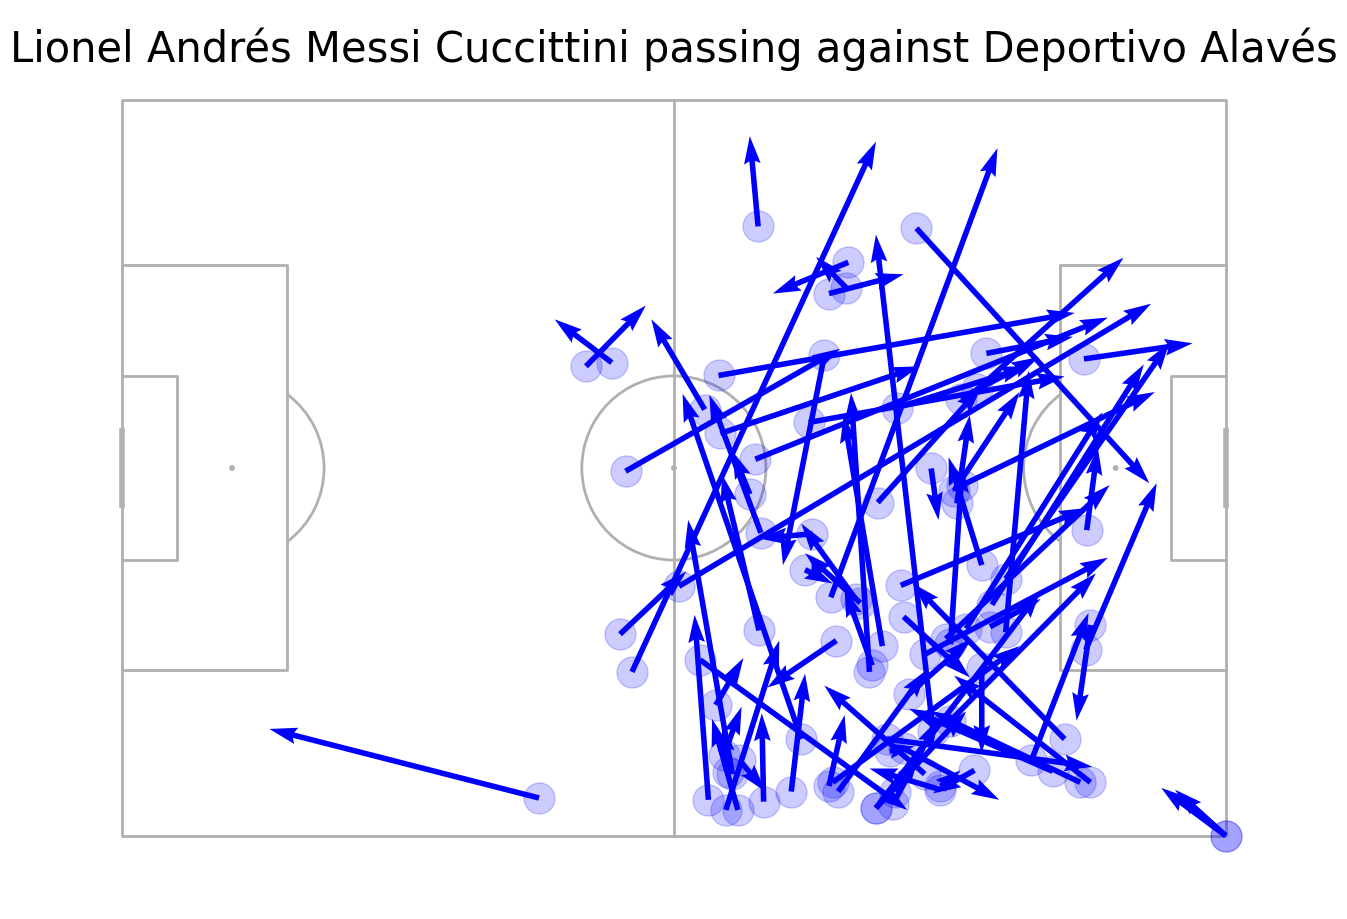

In [ ]:
import matplotlib as mpl
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
player_name = 'Lionel Andrés Messi Cuccittini'
pitch = Pitch()
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
df_pass = pass_data.filter(
    lambda e: e.player.name==player_name and e.raw_event['play_pattern']!='From Throw In'
).to_df()
pitch.arrows(
    df_pass.coordinates_x, df_pass.coordinates_y,
    df_pass.end_coordinates_x, df_pass.end_coordinates_y,
    color = "blue", ax=ax['pitch']
)
pitch.scatter(
    df_pass.coordinates_x,
    df_pass.coordinates_y,
    alpha = 0.2, s = 500, color = "blue", ax=ax['pitch']
)
fig.suptitle('%s passing against %s'%(player_name, team2.name), fontsize = 30)
plt.show()


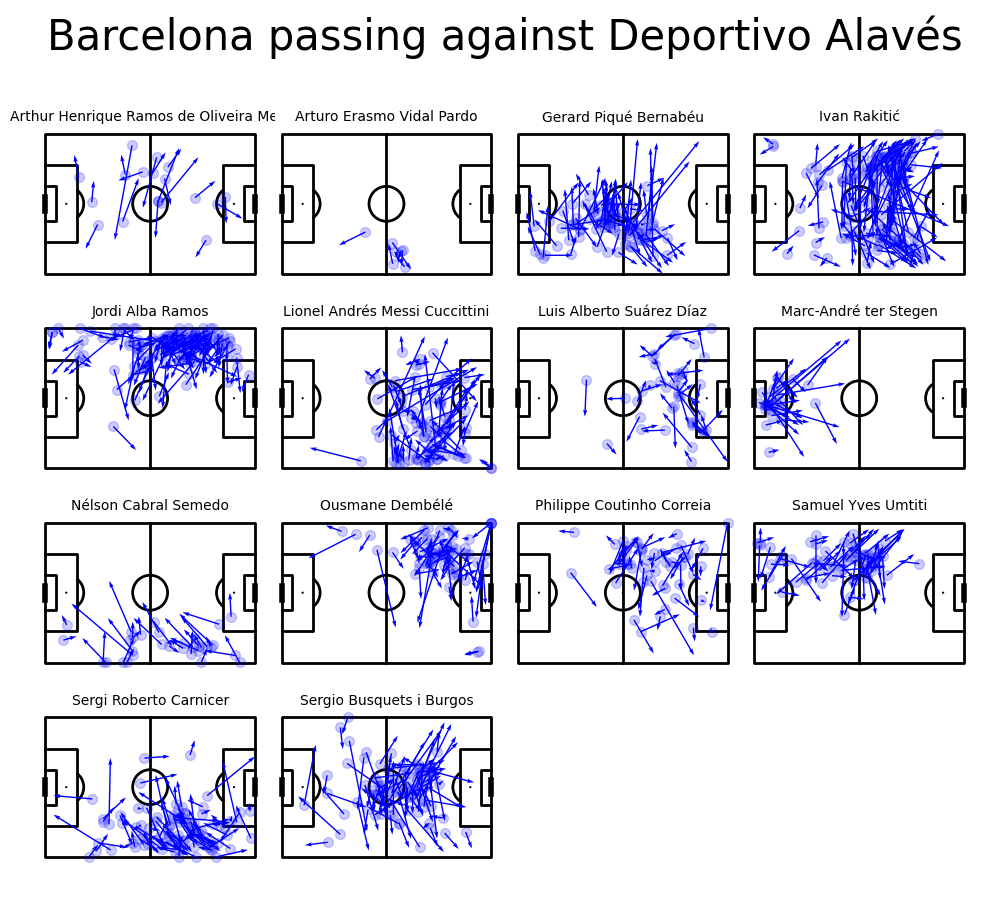

In [ ]:
team_pass_df = pass_data.filter(
    lambda e: e.team.name==team1.name and e.raw_event['play_pattern']!='From Throw In'
).to_df(
    '*coordinates*',
    lambda e: {'player_name': e.player.name}
)
dfs = dict(tuple(team_pass_df.groupby('player_name')))

pitch = Pitch(line_color='black', pad_top=20)
fig, axs = pitch.grid(
    ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
    endnote_height=0.04, title_space=0.04, endnote_space=0.01
)
for name, ax in zip(dfs.keys(), axs['pitch'].flat[:len(dfs.keys())]):
    ax.text(
        60, -10, name,
        ha='center', va='center', fontsize=10
    )
    player_df = dfs[name]
    pitch.scatter(
        player_df.coordinates_x,
        player_df.coordinates_y,
        alpha = 0.2, s = 50, color = "blue", ax=ax
    )
    pitch.arrows(
        player_df.coordinates_x,
        player_df.coordinates_y,
        player_df.end_coordinates_x,
        player_df.end_coordinates_y,
        color = "blue", ax=ax, width=1
    )
for ax in axs['pitch'][-1, 16 - len(dfs.keys()):]:
    ax.remove()

axs['title'].text(
    0.5, 0.5, '%s passing against %s'%(team1.name, team2.name),
    ha='center', va='center', fontsize=30
)
plt.show()

<ipython-input-7-b4b6e31511f2>:12: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  ).to_pandas(


Text(0.5, 0.98, 'Barcelona passing data vs Deportivo Alavés')

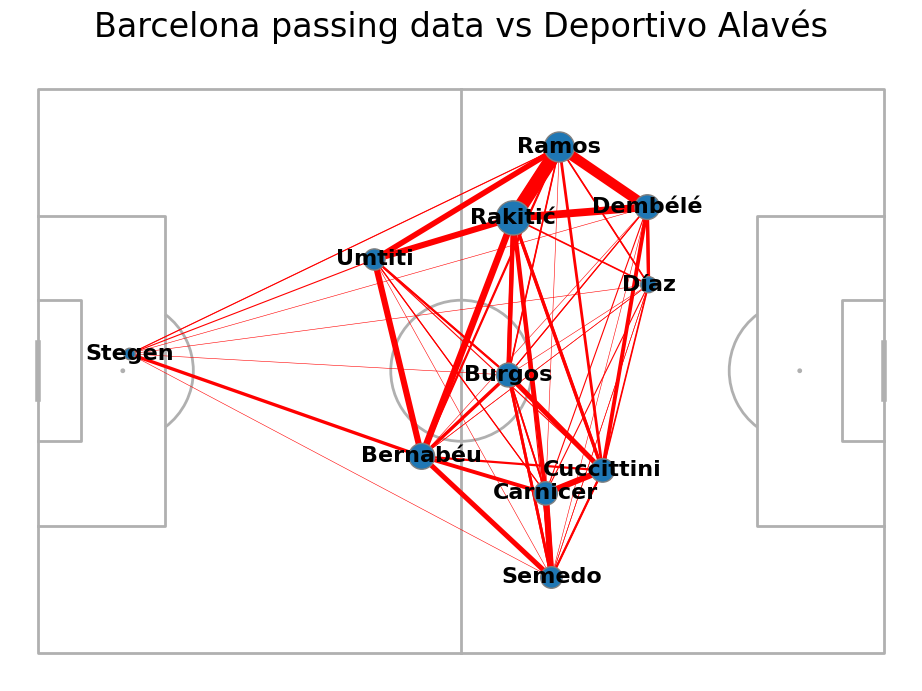

In [ ]:
# 找出第一次换人事件，只分析第一次换人之前的传球网络
subst = dataset.find('substitution')

# 'pass.complete'表示只保留成功的传球事件
# 这里多次调用了filter对数据集进行过滤
# 筛选出在第一次换人之前的传球事件集
# 只需要一只队伍的数据
df = dataset.filter('pass.complete').filter(
    # 事件的index表示了所有事件在数据集中的顺序
    # 使用index，我们可以过滤出发生在换人之前的所有事件
    lambda e: e.raw_event['index'] < subst.raw_event['index'] and e.team.name == team1.name
).to_pandas(
    # 在转换成pandas DataFrame时，添加球员名字和队伍名称两个列
    additional_columns={
        'player_name': lambda event: str(event.player),
        'receiver_name': lambda event: str(event.receiver_player)
    }
)

# 洁癖专用
# 把列名过滤一下，只留下必要的列
df = df[['player_name', 'receiver_name',
    'coordinates_x', 'coordinates_y',
    'end_coordinates_x', 'end_coordinates_y'
]]

# 计算每个球员的位置
# 聚合每个球员传球和接球的位置坐标和与次数
# 是否存在更Pythonic的方式进行数据聚合？
outgoing_x = df.groupby(['player_name'])[['coordinates_x']].agg(['sum', 'count'])
outgoing_x.columns = outgoing_x.columns.droplevel(0)
outgoing_y = df.groupby(['player_name'])[['coordinates_y']].agg(['sum', 'count'])
outgoing_y.columns = outgoing_y.columns.droplevel(0)
incoming_x = df.groupby(['receiver_name'])[['end_coordinates_x']].agg(['sum', 'count'])
incoming_x.columns = incoming_x.columns.droplevel(0)
incoming_y = df.groupby(['receiver_name'])[['end_coordinates_y']].agg(['sum', 'count'])
incoming_y.columns = incoming_y.columns.droplevel(0)
pos_x = outgoing_x + incoming_x
pos_y = outgoing_y + incoming_y

pos = pd.DataFrame(pos_x.index).set_index('player_name')

pos['x'] = pos_x['sum']/pos_x['count']
pos['y'] = pos_y['sum']/pos_y['count']

# 按照最大传球数量设定上限
max_count = outgoing_x['count'].max()

# 计算每两个球员之间的传球数量
passes_count = df.groupby(['player_name', 'receiver_name']).agg(['count'])
# 删除多级的列名
passes_count.columns = passes_count.columns.droplevel(0)
# 去掉重复的列
passes_count = passes_count.loc[:,~passes_count.columns.duplicated()].copy().reset_index()

# 开始画图的部分
import matplotlib as mpl
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt

# matplotlib在Linux下的中文
mpl.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

pitch = Pitch()
fig, ax = pitch.draw(figsize=(10, 7))

# 标识球员的平均位置
pitch.scatter(
    pos['x'], pos['y'],
    s=pos_x['count']/max_count*300,
    edgecolors='grey', linewidth=1, alpha=1,
    ax=ax, zorder = 3
)

# 标识名字
for _, row in pos.iterrows():
    pitch.annotate(
        # 全名太长了，只取最后一个单词
        # 所以还能认出哪个是梅西吗？
        row.name.split()[-1],
        xy=(row.x, row.y),
        c='black', va='center', ha='center',
        weight = "bold", size=16, ax=ax, zorder = 4
    )

# 画边
for _, row in passes_count.iterrows():
    pitch.lines(
        pos.loc[row['player_name']].x,
        pos.loc[row['player_name']].y,
        pos.loc[row['receiver_name']].x,
        pos.loc[row['receiver_name']].y,
        alpha=1, zorder=2, color="red", ax = ax,
        lw=row['count']/passes_count['count'].max()*10
    )

fig.suptitle('%s passing data vs %s'%(team1.name, team2.name), fontsize = 24)

In [ ]:
import pandas as pd
import os
from kloppy import statsbomb
team = 'Barcelona'
pass_to_shot = pd.DataFrame()
shots = dataset.filter('shot').filter(lambda e: e.team.name==team).to_df()
from kloppy.domain import SetPieceQualifier
passes = dataset.filter('pass.complete').filter(lambda e: e.team.name==team).filter(
    lambda e: 'type' not in e.raw_event['pass'])
df = passes.to_pandas(
        additional_columns={
            'player_name': lambda e: str(e.player)
        }
)
df = df[['player_name', 'period_id',
        'timestamp', 'coordinates_x', 'coordinates_y',
        'end_coordinates_x', 'end_coordinates_y']]
df.rename(columns={
        'coordinates_x':'x', 'coordinates_y':'y',
        'end_coordinates_x': 'end_x',
        'end_coordinates_y': 'end_y'
        }, inplace=True)
passes_df = df[df.apply(
    lambda x: True in (
        ((x.timestamp.total_seconds() + 15) > shots[shots['period_id'] == x.period_id]['timestamp'].dt.total_seconds()) &
        (x.timestamp.total_seconds() < shots[shots['period_id'] == x.period_id]['timestamp'].dt.total_seconds())
    ).unique(),
    axis=1
)]
pass_to_shot = pd.concat([pass_to_shot, passes_df])

print(pass_to_shot)
print(pass_to_shot.shape)

<ipython-input-8-b97f19f69aea>:10: DeprecationWarning: Call to deprecated function to_pandas (to_pandas will be removed in the future. Please use to_df instead.).
  df = passes.to_pandas(


                        player_name  period_id              timestamp      x  \
27            Marc-André ter Stegen          1 0 days 00:02:17.086000  12.65   
28            Gerard Piqué Bernabéu          1 0 days 00:02:20.166000  31.05   
29                     Ivan Rakitić          1 0 days 00:02:24.528000  50.25   
58                  Ousmane Dembélé          1 0 days 00:05:27.809000  94.55   
59   Lionel Andrés Messi Cuccittini          1 0 days 00:05:37.731000  96.05   
..                              ...        ...                    ...    ...   
719           Gerard Piqué Bernabéu          2 0 days 00:44:18.751000  85.35   
720          Sergi Roberto Carnicer          2 0 days 00:44:19.509000  96.25   
738                    Ivan Rakitić          2 0 days 00:46:31.727000  64.85   
739                Jordi Alba Ramos          2 0 days 00:46:35.420000  90.05   
740        Luis Alberto Suárez Díaz          2 0 days 00:46:39.111000  81.05   

         y   end_x  end_y  
27   28.55 

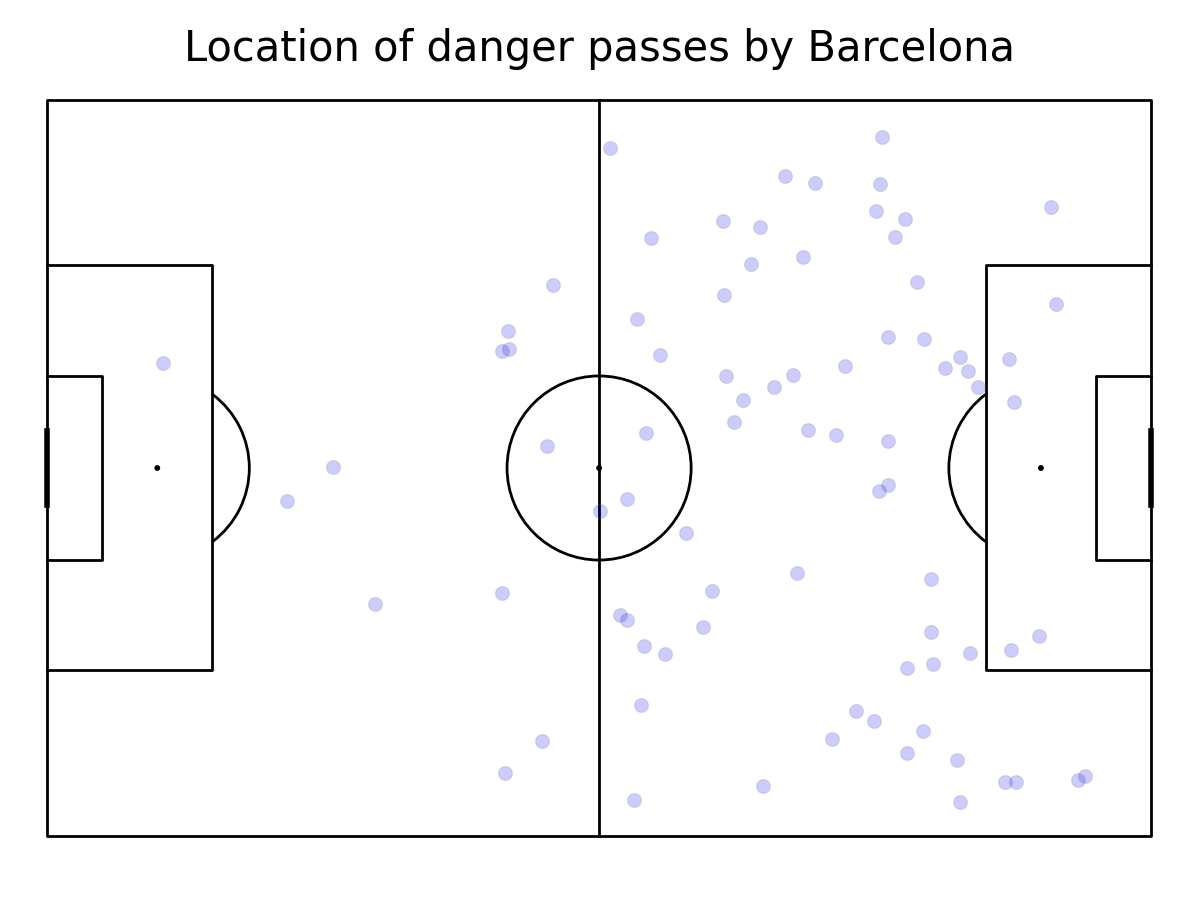

In [ ]:
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(pass_to_shot.x, pass_to_shot.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
fig.suptitle('Location of danger passes by Barcelona', fontsize = 30)
plt.show()

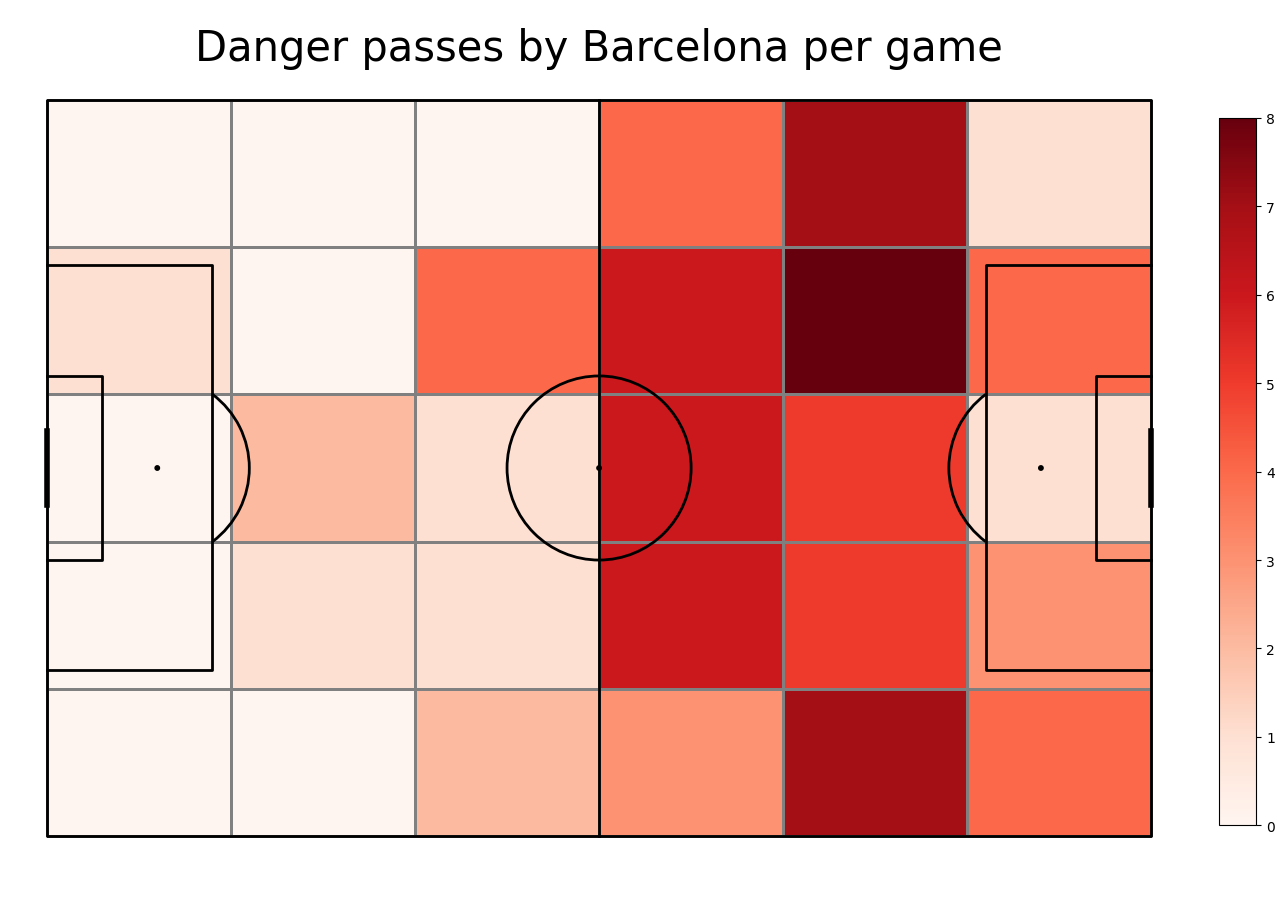

In [ ]:
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(
    pass_to_shot.x, pass_to_shot.y,
    statistic='count', bins=(6, 5),
    normalize=False
)

pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()